# Analyzing  DIS open data
This jupyter Notebook will analyze some of the DIS open data from NZA (https://www.opendisdata.nl). It can be used online as well as offline. For offline use the data from the site needs to be downloaded to a 'data'-folder within the folder of this Notebook

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import csv

#Select the diagnoses for analysis. Diagnosis are selected based on the combination of SPECIALISM and DIAGNOSIS
spec_diag_ID = ['0330'+'1201','0330'+'1203','0308'+'1201','0308'+'2505','0308'+'2560'] #All HNP-diagnoses
#spec_diag_ID = ['0330'+'0531'] #Multiple sclerose
#spec_diag_ID = ['0330'+'1111'] #Onbloedige beroerte
#spec_diag_ID = ['0330'+'1203'] #Radiculair syndroom / HNP lumbaal-thoracaal

#For some graph(s) you can choose whether to plot information from the selected diagnoses or the here indicated specialism.
spec_ID = ['0330'] #neurologie

#When True, the code will try to connect to the data-files through http.
#When False, make sure to download the files to the 'data' folder
online = True 

#When True, the code will save a few of the acquired DataFrames to csv for further analysis in e.g. Excel
exportToCSV = True

#Information about the completeness of the data as found on the data website [20190415]
volledigheid = {'2012':100,'2013':100,'2014':100,'2015':95,'2016':95,'2017':95,'2018':60,'2019':0}

def drop_suffix(df, suffix):
    # list comprehension of the cols that end with '_y'
    to_drop = [x for x in df if x.endswith(suffix)]
    df.drop(to_drop, axis=1, inplace=True)
    
def correctNumberOfPatients(df,yearColumn,corrections,correctColumns):
    df['volledigheid'] = df[yearColumn].map(corrections)
    for column in correctColumns:
        df[column] = round(df[column] * 100.0 / df['volledigheid'], 0)
    df.drop('volledigheid', axis=1, inplace=True)
    df[yearColumn] = pd.to_datetime(df[yearColumn])

Here, the first csv-file (**DBC-zorgproducten per jaar, specialisme, diagnose**) is read and parsed. According to the description found on the site, it contains the following (Dutch):

_Elke regel in deze tabel beschrijft een geregistreerd zorgproduct binnen een specialisme/diagnosecombinatie. Hiervan is het aantal geregistreerde DBC-trajecten, het aantal patiënten en - indien vastgesteld - de landelijk gemiddelde verkoopprijs opgenomen. Daarnaast staat ook het totale aantal DBC-trajecten en patiënten vermeld voor de betreffende combinatie van specialisme/diagnose, en ook het totaal voor het betreffende specialisme. Deze staan vermeld op elke regel van een zorgproduct dat hieronder valt, wat het op zich overbodig maak, maar toch handig kan zijn voor verwerking._

In [2]:
if online:
    url = 'https://www.opendisdata.nl/download/csv/01_DBC.csv'
else:
    url = 'data/01_DBC.csv'

df_dbc = pd.read_csv(url, sep=',', header=0, dtype={'JAAR':str,'BEHANDELEND_SPECIALISME_CD':str,'TYPERENDE_DIAGNOSE_CD':str, 'ZORGPRODUCT_CD': str}, na_values={'ZORGPRODUCT_CD':'clear all'})

#remove unncessary columns, duplicates and reset the index
list_to_drop = ['VERSIE','DATUM_BESTAND','PEILDATUM']
df_dbc = df_dbc.drop(columns=list_to_drop).drop_duplicates().reset_index(drop=True)

#df_dbc[df_dbc['JAAR']=='2018'].head()
df_dbc.head()
#df_dbc.info()

,JAAR,BEHANDELEND_SPECIALISME_CD,TYPERENDE_DIAGNOSE_CD,ZORGPRODUCT_CD,AANTAL_PAT_PER_ZPD,AANTAL_SUBTRAJECT_PER_ZPD,AANTAL_PAT_PER_DIAG,AANTAL_SUBTRAJECT_PER_DIAG,AANTAL_PAT_PER_SPC,AANTAL_SUBTRAJECT_PER_SPC,GEMIDDELDE_VERKOOPPRIJS
0,2012,0322,1105,109699018,983,992,3618,4450,420610,622238,1275.0
1,2012,0322,1105,109699008,284,294,3618,4450,420610,622238,5045.0
2,2012,0322,1105,109699002,93,93,3618,4450,420610,622238,265.0
3,2012,0322,1105,109699007,2,2,3618,4450,420610,622238,NaN
4,2012,0322,1105,109699010,6,6,3618,4450,420610,622238,NaN


Here, the second csv-file (**Zorgactiviteiten per jaar, specialisme, diagnose, zorgproduct**) is read and parsed. No additional information concerning this table is provided on the site:

During chunkwise-parsing only the information pertaining to the selected diagnoses (spec_diag_ID) is kept.

In [3]:
if online:
    url = 'https://www.opendisdata.nl/download/csv/02_DBC_PROFIEL.csv'
else:
    url = 'data/02_DBC_PROFIEL.csv'
    
#create empty DataFrame
df_dbc_profiel_diag = pd.DataFrame()

#define chunk size
chunksize = 10000

#create reader for chunk-wise reading of large .csv
reader = pd.read_csv(url, sep=',', header=0, dtype={'JAAR':str,'BEHANDELEND_SPECIALISME_CD':str,'ZORGACTIVITEIT_CD':str,'ZORGPRODUCT_CD':str,'ZORGPROFIELKLASSE_CD':str}, chunksize=chunksize)

#only keep information related to the selected diagnoses
for chunk in reader:
    chunk['spec_diag'] = chunk['BEHANDELEND_SPECIALISME_CD'] + chunk['TYPERENDE_DIAGNOSE_CD']
    df = chunk.loc[ chunk['spec_diag'].isin(spec_diag_ID) ]
    df_dbc_profiel_diag = pd.concat([df_dbc_profiel_diag,df])

#remove unncessary columns, duplicates and reset the index
list_to_drop = ['VERSIE','DATUM_BESTAND','PEILDATUM','spec_diag']
df_dbc_profiel_diag = df_dbc_profiel_diag.drop(columns=list_to_drop).drop_duplicates().reset_index(drop=True)

df_dbc_profiel_diag.head()

,JAAR,BEHANDELEND_SPECIALISME_CD,TYPERENDE_DIAGNOSE_CD,ZORGPRODUCT_CD,ZORGACTIVITEIT_CD,ZORGPROFIELKLASSE_CD,AANTAL_PAT,AANTAL_SUBTRAJECT,AANTAL_ZAT
0,2012,0308,2560,131999226,038441,5,94,95,98
1,2012,0308,1201,972802024,030135,5,1,1,1
2,2012,0308,2505,131999242,190013,1,91,92,107
3,2012,0308,1201,972802023,190035,2,200,204,218
4,2012,0308,1201,972802024,034503,5,2,2,2


The number of patients needs to be corrected for the _'volledigheid'_.

In [4]:
#print(df_dbc[df_dbc['JAAR']=='2018']['AANTAL_PAT_PER_DIAG'].head())

columns_to_correct = ['AANTAL_PAT_PER_DIAG','AANTAL_SUBTRAJECT_PER_DIAG','AANTAL_PAT_PER_SPC','AANTAL_SUBTRAJECT_PER_SPC']
correctNumberOfPatients(df_dbc,'JAAR',volledigheid,columns_to_correct)

#df_dbc[df_dbc['JAAR']=='2018']['AANTAL_PAT_PER_DIAG'].head()
df_dbc.head()

,JAAR,BEHANDELEND_SPECIALISME_CD,TYPERENDE_DIAGNOSE_CD,ZORGPRODUCT_CD,AANTAL_PAT_PER_ZPD,AANTAL_SUBTRAJECT_PER_ZPD,AANTAL_PAT_PER_DIAG,AANTAL_SUBTRAJECT_PER_DIAG,AANTAL_PAT_PER_SPC,AANTAL_SUBTRAJECT_PER_SPC,GEMIDDELDE_VERKOOPPRIJS
0,2012-01-01,0322,1105,109699018,983,992,3618.0,4450.0,420610.0,622238.0,1275.0
1,2012-01-01,0322,1105,109699008,284,294,3618.0,4450.0,420610.0,622238.0,5045.0
2,2012-01-01,0322,1105,109699002,93,93,3618.0,4450.0,420610.0,622238.0,265.0
3,2012-01-01,0322,1105,109699007,2,2,3618.0,4450.0,420610.0,622238.0,NaN
4,2012-01-01,0322,1105,109699010,6,6,3618.0,4450.0,420610.0,622238.0,NaN


In [5]:
#print(df_dbc_profiel_diag[df_dbc_profiel_diag['JAAR']=='2018']['AANTAL_PAT'].head())

columns_to_correct = ['AANTAL_PAT','AANTAL_SUBTRAJECT','AANTAL_ZAT']
correctNumberOfPatients(df_dbc_profiel_diag,'JAAR',volledigheid,columns_to_correct)

#df_dbc_profiel_diag[df_dbc_profiel_diag['JAAR']=='2018']['AANTAL_PAT'].head()
df_dbc_profiel_diag.head()

,JAAR,BEHANDELEND_SPECIALISME_CD,TYPERENDE_DIAGNOSE_CD,ZORGPRODUCT_CD,ZORGACTIVITEIT_CD,ZORGPROFIELKLASSE_CD,AANTAL_PAT,AANTAL_SUBTRAJECT,AANTAL_ZAT
0,2012-01-01,0308,2560,131999226,038441,5,94.0,95.0,98.0
1,2012-01-01,0308,1201,972802024,030135,5,1.0,1.0,1.0
2,2012-01-01,0308,2505,131999242,190013,1,91.0,92.0,107.0
3,2012-01-01,0308,1201,972802023,190035,2,200.0,204.0,218.0
4,2012-01-01,0308,1201,972802024,034503,5,2.0,2.0,2.0


Here, the third csv-file (**Referentietabel zorgactiviteiten**) is read and parsed. According to the description found on the site, it contains the following (Dutch):
    
_Van elk DBC-zorgproduct is een omschrijving opgenomen in deze referentietabel. Hierbij is de laatst opgenomen omschrijving gebruikt. Deze kan historisch gezien kan afwijken. Een uitgebreide referentietabel met een beschrijving van de code per release van de systematiek is beschikbaar op de website van Werken met DBC’s onder de releases van de ziekenhuiszorg._

In [6]:
if online:
    url = 'https://www.opendisdata.nl/download/csv/03_REF_ZAT.csv'
else:
    url = 'data/03_REF_ZAT.csv'

df_ref_zat_full = pd.read_csv(url, sep=',', header=0, dtype={'ZORGACTIVITEIT_CD':str,'ZORGPROFIELKLASSE_CD':str})

list_to_drop = ['VERSIE','DATUM_BESTAND','PEILDATUM']
df_ref_zat_full = df_ref_zat_full.drop(columns=list_to_drop).drop_duplicates().reset_index(drop=True)

df_ref_zat_full.head()
#df_ref_zat.info()

,ZORGACTIVITEIT_CD,OMSCHRIJVING,ZORGPROFIELKLASSE_CD,ZORGPROFIELKLASSE_OMS
0,039815,Diagnostische voorste oogkamerpunctie.,4,DIAGNOSTISCHE ACTIVITEITEN
1,038945,Behandeling wond met wondrandexcisie (o.a. nec...,5,OPERATIEVE VERRICHTINGEN
2,039139,Verstrekking immunomodulerende middelen door k...,6,OVERIGE THERAPEUTISCHE ACTIVITEITEN
3,032201,Laryngofissuur.,5,OPERATIEVE VERRICHTINGEN
4,038860,"Hechten van een of twee strekpezen, per pees.",5,OPERATIEVE VERRICHTINGEN


Turn the reference table into a reference table just for ZORGACTIVITEIT.

In [7]:
df_ref_zat = df_ref_zat_full[['ZORGACTIVITEIT_CD','OMSCHRIJVING']].rename(index=str, columns={"OMSCHRIJVING":"ZORGACTIVITEIT_OMSCHRIJVING"}).drop_duplicates().reset_index(drop=True)
df_ref_zat.head()

,ZORGACTIVITEIT_CD,ZORGACTIVITEIT_OMSCHRIJVING
0,039815,Diagnostische voorste oogkamerpunctie.
1,038945,Behandeling wond met wondrandexcisie (o.a. nec...
2,039139,Verstrekking immunomodulerende middelen door k...
3,032201,Laryngofissuur.
4,038860,"Hechten van een of twee strekpezen, per pees."


... and one just for ZORGPROFIELKLASSE

In [8]:
df_ref_zpf = df_ref_zat_full[['ZORGPROFIELKLASSE_CD','ZORGPROFIELKLASSE_OMS']].drop_duplicates().reset_index(drop=True)
df_ref_zpf

,ZORGPROFIELKLASSE_CD,ZORGPROFIELKLASSE_OMS
0,4,DIAGNOSTISCHE ACTIVITEITEN
1,5,OPERATIEVE VERRICHTINGEN
2,6,OVERIGE THERAPEUTISCHE ACTIVITEITEN
3,3,KLINIEK
4,7,BEELDVORMENDE DIAGNOSTIEK
5,16,GERIATRISCHE REVALIDATIE
6,2,DAGVERPLEGING
7,1,"POLIKLINIEK-, EERSTE HULPBEZOEK EN CONSULTATIE..."
8,1,POLIKLINIEK- EN EERSTE HULPBEZOEK


Here, the fourth csv-file (**Referentietabel diagnoses**) is read and parsed. According to the description found on the site, it contains the following (Dutch):

_Van elke combinatie van specialisme/diagnose is een omschrijving opgenomen in deze referentietabel. Hierbij is de laatst opgenomen omschrijving gebruikt. Deze kan historisch gezien afwijken. Een uitgebreide referentietabel met een beschrijving van de code per release van de systematiek is beschikbaar op de website van Werken met DBC’s onder de releases van de ziekenhuiszorg._

In [9]:
if online:
    url = 'https://www.opendisdata.nl/download/csv/04_REF_DGN.csv'
else:
    url = 'data/04_REF_DGN.csv'
    
df_ref_dgn = pd.read_csv(url, sep=',', header=0, dtype={'DIAGNOSE_CD':str,'SPECIALISME_CD':str})

list_to_drop = ['VERSIE','DATUM_BESTAND','PEILDATUM']
df_ref_dgn = df_ref_dgn.drop(columns=list_to_drop).drop_duplicates().reset_index(drop=True)

df_ref_dgn.head()
#df_ref_dgn.info()

,DIAGNOSE_CD,SPECIALISME_CD,DIAGNOSE_OMSCHRIJVING
0,55,0302,Globus / slikklachten
1,330,0303,maligne neoplasma maag
2,2103,0316,leverfunctiestoornissen
3,107,0318,stationaire oesofagus manometrie
4,001,0304,Eenvoudig 1 malig consult zonder behandeling <...


Here, the fifth csv-file (**Referentietabel zorgproducten**) is read and parsed. According to the description found on the site, it contains the following (Dutch):

_Van elk DBC-zorgproduct is een omschrijving opgenomen in deze referentietabel. Hierbij is de laatst opgenomen omschrijving gebruikt. Deze kan historisch gezien kan afwijken. Een uitgebreide referentietabel met een beschrijving van de code per release van de systematiek is beschikbaar op de website van Werken met DBC’s onder de releases van de ziekenhuiszorg._

In [10]:
if online:
    url = 'https://www.opendisdata.nl/download/csv/05_REF_ZPD.csv'
else:
    url = 'data/05_REF_ZPD.csv'
    
df_ref_zpd = pd.read_csv(url, sep=',', header=0, usecols=['ZORGPRODUCT_CD','LATIJN_OMS'], dtype={'ZORGPRODUCT_CD': str})

df_ref_zpd = df_ref_zpd.rename(index=str, columns={"LATIJN_OMS":"ZORGPRODUCT_LATIJN_OMS"})

df_ref_zpd.head()
#df_ref_zpd.info()

,ZORGPRODUCT_CD,ZORGPRODUCT_LATIJN_OMS
0,219699004,Uitval licht ambulant | Overig potentieel risico
1,979001009,Congenitale hartoperatie met ECC (complex) | Z...
2,979001104,Percutane coronaire interventie klasse 1 | Met...
3,990061032,T1 - Teletherapie standaard | Radiotherapie
4,028899017,Uitval intensieve/ invasieve therapie | Aandoe...


Here, the sixth csv-file (**Referentietabel specialismen**) is read and parsed. According to the description found on the site, it contains the following (Dutch):

_Van elk specialisme is een omschrijving opgenomen in deze referentietabel. Deze is gebaseerd op de COD016-VEKT codelijst.
Zie: https://www.vektis.nl/streams/standaardisatie/codelijsten/COD016-VEKT_

In [11]:
if online:
    url = 'https://www.opendisdata.nl/download/csv/06_REF_SPC.csv'
else:
    url = 'data/06_REF_SPC.csv'

df_ref_spc = pd.read_csv(url, sep=',', header=0, dtype={'SPECIALISME_CD':str})
df_ref_spc = df_ref_spc.rename(index=str, columns={"OMSCHRIJVING":"SPECIALISME_OMSCHRIJVING"})

list_to_drop = ['VERSIE','DATUM_BESTAND','PEILDATUM']
df_ref_spc = df_ref_spc.drop(columns=list_to_drop).drop_duplicates().reset_index(drop=True)

df_ref_spc.head()
#df_ref_spc.info()

,SPECIALISME_CD,SPECIALISME_OMSCHRIJVING
0,0601,"Ziekenhuizen, algemene ziekenhuizen"
1,9100,"Verpleegkundigen, niet nader gespecificeerd"
2,0533,"Stottertherapie, Hanen-ouderprogramma, Direct ..."
3,0403,"Fysiotherapeuten, kinderfysiotherapie"
4,0421,"Fysiotherapeuten, fysiotherapie in de geriatri..."


Here, we take a side-step and include the Dutch descriptions to the first DBC DataFrame. We drop a few columns which we don't really need and set 'JAAR' as the index.

In [12]:
#df_dbc.head()

df_dbc_full = pd.merge(df_dbc, df_ref_dgn, left_on=['TYPERENDE_DIAGNOSE_CD','BEHANDELEND_SPECIALISME_CD'], right_on=['DIAGNOSE_CD','SPECIALISME_CD'], how='left', suffixes=('','_dgn'))
drop_suffix(df_dbc_full, '_dgn')

df_dbc_full = pd.merge(df_dbc_full, df_ref_spc, left_on='BEHANDELEND_SPECIALISME_CD', right_on='SPECIALISME_CD', how='left', suffixes=('','_spc'))
drop_suffix(df_dbc_full, '_spc')

list_to_drop = ['DIAGNOSE_CD','SPECIALISME_CD']
df_dbc_full = df_dbc_full.drop(columns=list_to_drop)

df_dbc_full = df_dbc_full.set_index('JAAR')

df_dbc_full.head()

,BEHANDELEND_SPECIALISME_CD,TYPERENDE_DIAGNOSE_CD,ZORGPRODUCT_CD,AANTAL_PAT_PER_ZPD,AANTAL_SUBTRAJECT_PER_ZPD,AANTAL_PAT_PER_DIAG,AANTAL_SUBTRAJECT_PER_DIAG,AANTAL_PAT_PER_SPC,AANTAL_SUBTRAJECT_PER_SPC,GEMIDDELDE_VERKOOPPRIJS,DIAGNOSE_OMSCHRIJVING,SPECIALISME_OMSCHRIJVING
JAAR,,,,,,,,,,,,
2012-01-01,0322,1105,109699018,983,992,3618.0,4450.0,420610.0,622238.0,1275.0,Hemoptoë,"Medisch specialisten, longziekten"
2012-01-01,0322,1105,109699008,284,294,3618.0,4450.0,420610.0,622238.0,5045.0,Hemoptoë,"Medisch specialisten, longziekten"
2012-01-01,0322,1105,109699002,93,93,3618.0,4450.0,420610.0,622238.0,265.0,Hemoptoë,"Medisch specialisten, longziekten"
2012-01-01,0322,1105,109699007,2,2,3618.0,4450.0,420610.0,622238.0,NaN,Hemoptoë,"Medisch specialisten, longziekten"
2012-01-01,0322,1105,109699010,6,6,3618.0,4450.0,420610.0,622238.0,NaN,Hemoptoë,"Medisch specialisten, longziekten"


The different DataFrames are merged to include the Dutch description of the ZORGACTIVITEIT, DIAGNOSE, ZORGPRODUCT and SPECIALISME.

In [13]:
df_dbc_profiel_diag_full = pd.merge(df_dbc_profiel_diag, df_ref_zat, on='ZORGACTIVITEIT_CD', how='left', suffixes=('','_zat'))
drop_suffix(df_dbc_profiel_diag_full, '_zat')

df_dbc_profiel_diag_full = pd.merge(df_dbc_profiel_diag, df_ref_zpf, on='ZORGPROFIELKLASSE_CD', how='left', suffixes=('','_zat'))
drop_suffix(df_dbc_profiel_diag_full, '_zat')

df_dbc_profiel_diag_full = pd.merge(df_dbc_profiel_diag_full, df_ref_dgn, left_on=['TYPERENDE_DIAGNOSE_CD','BEHANDELEND_SPECIALISME_CD'], right_on=['DIAGNOSE_CD','SPECIALISME_CD'], how='left', suffixes=('','_dgn'))
drop_suffix(df_dbc_profiel_diag_full, '_dgn')

df_dbc_profiel_diag_full = pd.merge(df_dbc_profiel_diag_full, df_ref_zpd, on='ZORGPRODUCT_CD', how='left', suffixes=('','_zpd'))
drop_suffix(df_dbc_profiel_diag_full, '_zpod')

df_dbc_profiel_diag_full = pd.merge(df_dbc_profiel_diag_full, df_ref_spc, left_on='BEHANDELEND_SPECIALISME_CD', right_on='SPECIALISME_CD', how='left', suffixes=('','_spc'))
drop_suffix(df_dbc_profiel_diag_full, '_spc')

list_to_drop = ['DIAGNOSE_CD','SPECIALISME_CD']
df_dbc_profiel_diag_full = df_dbc_profiel_diag_full.drop(columns=list_to_drop).drop_duplicates().set_index('JAAR')

if exportToCSV:
    df_dbc_profiel_diag_full.to_csv('data/dbc_profiel_diag.csv', index=True)
df_dbc_profiel_diag_full.head()

,BEHANDELEND_SPECIALISME_CD,TYPERENDE_DIAGNOSE_CD,ZORGPRODUCT_CD,ZORGACTIVITEIT_CD,ZORGPROFIELKLASSE_CD,AANTAL_PAT,AANTAL_SUBTRAJECT,AANTAL_ZAT,ZORGPROFIELKLASSE_OMS,DIAGNOSE_OMSCHRIJVING,ZORGPRODUCT_LATIJN_OMS,SPECIALISME_OMSCHRIJVING
JAAR,,,,,,,,,,,,
2012-01-01,0308,2560,131999226,038441,5,94.0,95.0,98.0,OPERATIEVE VERRICHTINGEN,Operaties wegens recidief HNP lumbaal,Oper wervelkolom middelzwaar wo recidief HNP |...,"Medisch specialisten, neurochirurgie"
2012-01-01,0308,1201,972802024,030135,5,1.0,1.0,1.0,OPERATIEVE VERRICHTINGEN,"Conservatieve behandeling, incl. evt drukregis...",Neurochirurgie | Hersenchirurgie zwaartegroep ...,"Medisch specialisten, neurochirurgie"
2012-01-01,0308,2505,131999242,190013,1,91.0,92.0,107.0,"POLIKLINIEK-, EERSTE HULPBEZOEK EN CONSULTATIE...","HNP,chemonucleolysis en percutane nucleotomie ...",Oper wervelkolom middelzwaar wo HNP/ laminecto...,"Medisch specialisten, neurochirurgie"
2012-01-01,0308,2505,131999242,190013,1,91.0,92.0,107.0,POLIKLINIEK- EN EERSTE HULPBEZOEK,"HNP,chemonucleolysis en percutane nucleotomie ...",Oper wervelkolom middelzwaar wo HNP/ laminecto...,"Medisch specialisten, neurochirurgie"
2012-01-01,0308,1201,972802023,190035,2,200.0,204.0,218.0,DAGVERPLEGING,"Conservatieve behandeling, incl. evt drukregis...",Neurochirurgie | Hersenchirurgie zwaartegroep ...,"Medisch specialisten, neurochirurgie"


Get overview of unique SPECIALISME-DIAGNOSE-ZORGPRODUCT-ZORGACTIVITEIT combinations

In [14]:
list_to_drop = ['AANTAL_PAT','AANTAL_SUBTRAJECT','AANTAL_ZAT']
df_diag_overview = df_dbc_profiel_diag_full.drop(columns=list_to_drop).drop_duplicates().reset_index()

list_to_drop = ['JAAR','BEHANDELEND_SPECIALISME_CD','TYPERENDE_DIAGNOSE_CD','ZORGPRODUCT_CD','ZORGACTIVITEIT_CD','ZORGPROFIELKLASSE_CD']
df_diag_overview = df_diag_overview.drop(columns=list_to_drop).drop_duplicates()

if exportToCSV:
    df_diag_overview.to_csv('data/diag_overview.csv', index=False, quoting=csv.QUOTE_ALL)
    
df_diag_overview

,ZORGPROFIELKLASSE_OMS,DIAGNOSE_OMSCHRIJVING,ZORGPRODUCT_LATIJN_OMS,SPECIALISME_OMSCHRIJVING
0,OPERATIEVE VERRICHTINGEN,Operaties wegens recidief HNP lumbaal,Oper wervelkolom middelzwaar wo recidief HNP |...,"Medisch specialisten, neurochirurgie"
1,OPERATIEVE VERRICHTINGEN,"Conservatieve behandeling, incl. evt drukregis...",Neurochirurgie | Hersenchirurgie zwaartegroep ...,"Medisch specialisten, neurochirurgie"
2,"POLIKLINIEK-, EERSTE HULPBEZOEK EN CONSULTATIE...","HNP,chemonucleolysis en percutane nucleotomie ...",Oper wervelkolom middelzwaar wo HNP/ laminecto...,"Medisch specialisten, neurochirurgie"
3,POLIKLINIEK- EN EERSTE HULPBEZOEK,"HNP,chemonucleolysis en percutane nucleotomie ...",Oper wervelkolom middelzwaar wo HNP/ laminecto...,"Medisch specialisten, neurochirurgie"
4,DAGVERPLEGING,"Conservatieve behandeling, incl. evt drukregis...",Neurochirurgie | Hersenchirurgie zwaartegroep ...,"Medisch specialisten, neurochirurgie"
6,OVERIGE THERAPEUTISCHE ACTIVITEITEN,Operaties wegens recidief HNP lumbaal,Oper wervelkolom middelzwaar wo recidief HNP |...,"Medisch specialisten, neurochirurgie"
7,KLINIEK,Operaties wegens recidief HNP lumbaal,Oper wervelkolom middelzwaar wo recidief HNP |...,"Medisch specialisten, neurochirurgie"
8,DIAGNOSTISCHE ACTIVITEITEN,"Conservatieve behandeling, incl. evt drukregis...",Neurochirurgie | Hersenchirurgie zwaartegroep ...,"Medisch specialisten, neurochirurgie"
9,OVERIGE THERAPEUTISCHE ACTIVITEITEN,"HNP,chemonucleolysis en percutane nucleotomie ...",Oper wervelkolom middelzwaar wo HNP/ laminecto...,"Medisch specialisten, neurochirurgie"
10,BEELDVORMENDE DIAGNOSTIEK,"HNP,chemonucleolysis en percutane nucleotomie ...",Oper wervelkolom middelzwaar wo HNP/ laminecto...,"Medisch specialisten, neurochirurgie"


Let's find the corrected number of patients for the selected diagnoses for each year (until 2018).

In [15]:
df_dbc_diag = df_dbc_full[['BEHANDELEND_SPECIALISME_CD','TYPERENDE_DIAGNOSE_CD','AANTAL_PAT_PER_DIAG','DIAGNOSE_OMSCHRIJVING']].drop_duplicates().sort_index()
#df_dbc_diag = df_dbc_profiel_diag_full[['BEHANDELEND_SPECIALISME_CD','TYPERENDE_DIAGNOSE_CD','AANTAL_PAT']].drop_duplicates().sort_index()
    
df_dbc_diag['spec_diag'] = df_dbc_diag['BEHANDELEND_SPECIALISME_CD'] + df_dbc_diag['TYPERENDE_DIAGNOSE_CD']
df_dbc_diag = df_dbc_diag.loc[ df_dbc_diag['spec_diag'].isin(spec_diag_ID) ]
df_dbc_diag = df_dbc_diag.drop(columns=['spec_diag'])
df_dbc_diag.head()

,BEHANDELEND_SPECIALISME_CD,TYPERENDE_DIAGNOSE_CD,AANTAL_PAT_PER_DIAG,DIAGNOSE_OMSCHRIJVING
JAAR,,,,
2012-01-01,0330,1203,55460.0,Radiculair syndroom / HNP lumbaal-thoracaal
2012-01-01,0330,1201,17273.0,Radiculair syndroom / HNP cervicaal
2012-01-01,0308,2560,1197.0,Operaties wegens recidief HNP lumbaal
2012-01-01,0308,2505,477.0,"HNP,chemonucleolysis en percutane nucleotomie ..."
2012-01-01,0308,1201,1192.0,"Conservatieve behandeling, incl. evt drukregis..."


In [16]:
df_dbc_diag_pat = pd.pivot_table(df_dbc_diag, index='JAAR', values='AANTAL_PAT_PER_DIAG', aggfunc=sum)

#remove 2019 (incomplete data)
df_dbc_diag_pat = df_dbc_diag_pat[:'2018']

df_dbc_diag_pat

,AANTAL_PAT_PER_DIAG
JAAR,
2012-01-01,75599.0
2013-01-01,78712.0
2014-01-01,78286.0
2015-01-01,78434.0
2016-01-01,80999.0
2017-01-01,79564.0
2018-01-01,66177.0


And, plot this...

c:\users\wouter\appdata\local\programs\python\python37-32\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


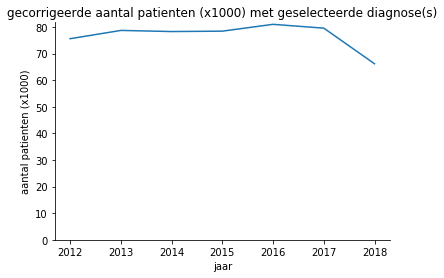

In [17]:
fig, ax = plt.subplots()
_ = plt.plot(df_dbc_diag_pat.index.values, df_dbc_diag_pat['AANTAL_PAT_PER_DIAG'].values / 1000)
_ = plt.title('gecorrigeerde aantal patienten (x1000) met geselecteerde diagnose(s)')
_ = plt.ylim(bottom=0)
_ = plt.xlabel('jaar')
_ = plt.ylabel('aantal patienten (x1000)')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

Back to the selected diagnoses. Let's find out the number of patients of the diagnoses with the most patients.

In [28]:
lastGraph = False
if lastGraph:
    df_dbc_full['spec_diag'] = df_dbc_full['BEHANDELEND_SPECIALISME_CD'] + df_dbc_full['TYPERENDE_DIAGNOSE_CD']
    df_dbc_spec = df_dbc_full.loc[ df_dbc_full['spec_diag'].isin(spec_diag_ID) ]
    df_dbc_full = df_dbc_full.drop(columns=['spec_diag'])
    analyse_naam = 'geselecteerde diagnoses'
else:
    df_dbc_spec = df_dbc_full.loc[ df_dbc_full['BEHANDELEND_SPECIALISME_CD'].isin(spec_ID) ]
    analyse_naam = 'specialisme ' + 'neurologie' #ToDo: select name from DataFrame

df_dbc_spec = df_dbc_spec.loc[:'2018',['AANTAL_PAT_PER_DIAG','DIAGNOSE_OMSCHRIJVING']]

df_dbc_spec = pd.pivot_table(df_dbc_spec, index='JAAR', columns='DIAGNOSE_OMSCHRIJVING', values='AANTAL_PAT_PER_DIAG', aggfunc=min)
df_dbc_spec = df_dbc_spec.loc[:, (df_dbc_spec.mean(axis=0) >= 25000)]

df_dbc_spec

DIAGNOSE_OMSCHRIJVING,Commotio / contusio cerebri,Epilepsie gegeneraliseerd,Migraine en migraine-varianten,Nervus medianus (inclusief CTS),Onbloedige beroerte,Overige hoofdpijn,Radiculair syndroom / HNP lumbaal-thoracaal
JAAR,,,,,,,
2012-01-01,37467.0,30145.0,25597.0,45301.0,36250.0,25549.0,55460.0
2013-01-01,40697.0,30997.0,26375.0,45066.0,38161.0,27572.0,56965.0
2014-01-01,45121.0,29545.0,26707.0,44271.0,39008.0,29790.0,56475.0
2015-01-01,46496.0,27869.0,26579.0,45204.0,40697.0,29588.0,56740.0
2016-01-01,42426.0,33721.0,27674.0,44765.0,40533.0,30993.0,58711.0
2017-01-01,38293.0,31682.0,25637.0,42660.0,39440.0,30079.0,56924.0
2018-01-01,29127.0,26667.0,24880.0,36458.0,37468.0,25300.0,47182.0


And plot this...

[]

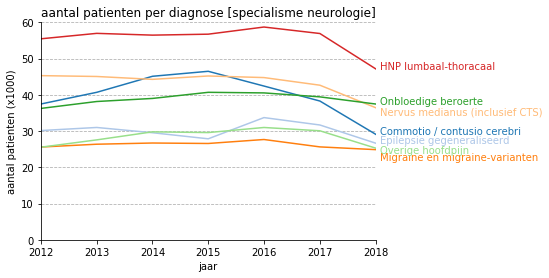

In [29]:
#http://www.randalolson.com/2014/06/28/how-to-make-beautiful-data-visualizations-in-python-with-matplotlib/

# These are the "Tableau 20" colors as RGB. 
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)
    
fig, ax = plt.subplots()
#_ = plt.plot(df_dbc_spec / 1000)
_ = plt.xlabel('jaar')
_ = plt.ylabel('aantal patienten (x1000)')
_ = plt.title('aantal patienten per diagnose [' + analyse_naam + ']')

x_min = df_dbc_spec.index.values[0]
x_max = df_dbc_spec.index.values[-1]
#x_min_value = pd.to_datetime(x_min).year
#x_max_value = pd.to_datetime(x_max).year
y_min = 0
y_max =  math.ceil((df_dbc_spec.max().max() / 1000) /10) * 10

# Limit the range of the plot to only where the data is.    
_ = plt.ylim(y_min, y_max)
_ = plt.xlim(x_min, x_max)

x_pos = df_dbc_spec.index.values[-1] + np.timedelta64('30','D')
for key, column in enumerate(df_dbc_spec.columns):
    y_pos = df_dbc_spec.iloc[-1,key] / 1000
    
    # to prevent overlapping labels, we need to shift them a bit
    if column == 'Nervus medianus (inclusief CTS)':
        y_pos -= 2
    elif column == 'Migraine en migraine-varianten':
        y_pos -= 3
    elif column == 'Overige hoofdpijn':
        y_pos -= 1.5
    
    # some diagnoses are a bit long, so let's make them shorter
    if column == 'Conservatieve behandeling, incl. evt drukregistratie en/of hydrocefalus behandeling + of - coiling':
        columnname = 'Conservatieve behandeling'
    elif column == 'HNP,chemonucleolysis en percutane nucleotomie of minimal invasive':
        columnname = 'HNP'
    elif column == 'Radiculair syndroom / HNP cervicaal':
        columnname = 'HNP cervicaal'
    elif column == 'Radiculair syndroom / HNP lumbaal-thoracaal':
        columnname = 'HNP lumbaal-thoracaal'
    else:
        columnname =  column
        
    _ = plt.plot(df_dbc_spec.index.values, df_dbc_spec[column].values / 1000, color=tableau20[key])
    _ = plt.text(x_pos, y_pos, columnname, color=tableau20[key])
    

# Remove the plot frame lines. 
_ = ax.spines["top"].set_visible(False)    
_ = ax.spines["right"].set_visible(False)    
_ = ax.grid(axis='y', linestyle='--', alpha=0.3, color='black')
plt.plot()

Let's use the overview of the selected diagnoses to get a feel of the use of ZORGPROFIELKLASSE 'BEELDVORMENDE DIAGNOSTIEK' and 'OPERATIEVE VERRICHTINGEN'.

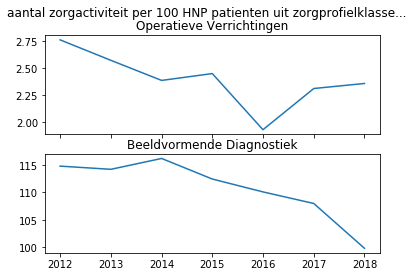

In [35]:
#df = df_dbc_profiel_diag_full[['ZORGACTIVITEIT_CD','AANTAL_ZAT','ZORGACTIVITEIT_OMSCHRIJVING','ZORGPROFIELKLASSE_OMS']]
df = pd.DataFrame(pd.pivot_table(df_dbc_profiel_diag_full, index='JAAR', columns='ZORGPROFIELKLASSE_OMS', values='AANTAL_ZAT', aggfunc=sum))
df = df[['BEELDVORMENDE DIAGNOSTIEK','OPERATIEVE VERRICHTINGEN']]
df = pd.concat([df_dbc_diag_pat, df], axis=1)
df['bld_part'] = df['BEELDVORMENDE DIAGNOSTIEK'] / df['AANTAL_PAT_PER_DIAG'] * 100
df['op_part'] = df['OPERATIEVE VERRICHTINGEN'] / df['AANTAL_PAT_PER_DIAG'] * 100
df.drop(columns=['AANTAL_PAT_PER_DIAG','BEELDVORMENDE DIAGNOSTIEK','OPERATIEVE VERRICHTINGEN'], inplace=True)
#print(df.head())

f, axarr = plt.subplots(2, sharex=True, sharey=False)
_ = f.suptitle('aantal zorgactiviteit per 100 HNP patienten uit zorgprofielklasse...')
_ = axarr[0].plot(df['op_part'])
_ = axarr[0].set_title('Operatieve Verrichtingen')
_ = axarr[1].plot(df['bld_part'])
_ = axarr[1].set_title('Beeldvormende Diagnostiek')